# Comparison of Selection algorithms

The purpose of this notebook is to show a comparison of different methods to select n from a set of R-groups.<br>
The methods that will be compared are:
 - The bbSelect 'som' and 'classic' selection methods
 - k-means clustering method (selecting centroids)
 - The Sphere exclusion method (selecting centroids)
 - The MaxMin selection method (Ashton, M. et. al., Quant. Struct.-Act. Relat., 21 (2002), 598)
 - Random selection
 
Analyses will be performed for each selection method
- For each method, the selection will be shown, followed by the coverage according to mGAP
- This is followed by a comparison of the Tanimoto similarities of each of the selection methods
- This is followed by a comparison of the physicochemical property distribution of the set


In [1]:
import sys
sys.path.append('../')
import logging
import matplotlib.pyplot as plt
import random
import numpy as np
from rdkit import Chem, SimDivFilters, DataStructs
from rdkit.Chem import Draw, rdMolDescriptors, AllChem
from rdkit.SimDivFilters import rdSimDivPickers
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

logging.basicConfig(format = '%(levelname)s - %(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S', level = logging.ERROR)

from bbSelect import Picker

plt.rcParams['figure.figsize'] = [15,10]


In [2]:
# To do
# Set up conda environment
    # To simplify the environments:
    # Ensure that
    # conda env create --name myenv -f environment.yml
    # example : https://github.com/gsk-tech/olivecrona-RNN/blob/master/packages.yml
    # mamba vs conda.

In [3]:
input_ref = '../data/enamine_acids/rdkit_conformers/enamine_acids_filtered_rdkit.ref'
input_bin = '../data/enamine_acids/rdkit_conformers/enamine_acids_filtered_rdkit.bin'
n_select = 48

## bbGAP self-organising map partitioning method
This is a selection method based on pharmacophore placement
- mGAP code located in mGapDBprocess.py, with a picker object similar to those used in RDKit
- Because some compounds fail conformer generation (due to bad smiles / stereochemistry which is not allowed), the compounds that pass will be used as the basis for the other selection methods

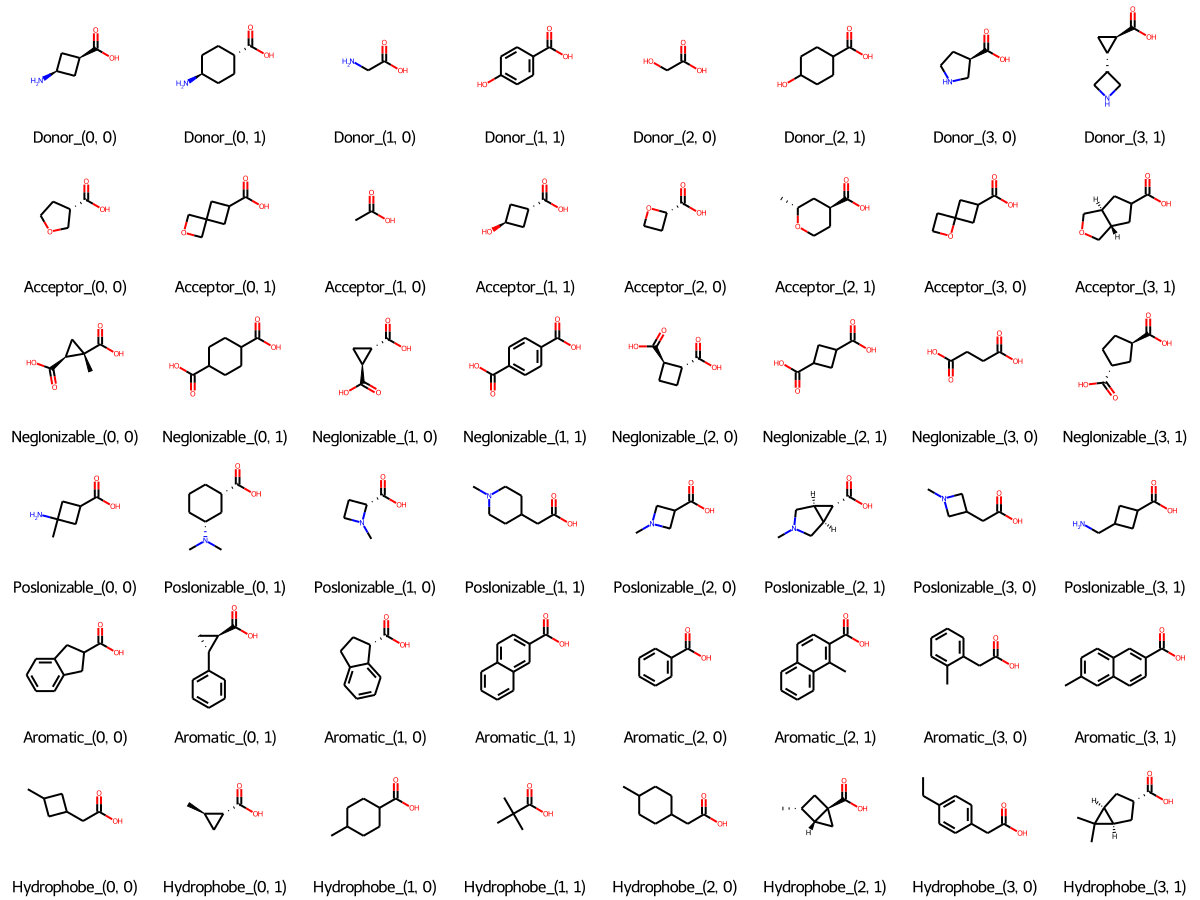

In [4]:
# run the bbGAP selection, using the SOM method
som_selection = Picker(ref_file = input_ref, 
                        bin_file = input_bin, 
                               n = n_select,  # How many compounds to select
                          method = 'som', # Which clustering method to use
                  pharmacophores = '*', # Which pharmacophore to select from,
                            ncpu = 10,  # Number of cpus to use,
                            sort = 'MPO',
                            tanimoto = 0.9,
                            use_coverage = False,)

#mGAPclustering = mGAP_selection._mGAPclustering 
som_selected_smiles_dict = som_selection.GetSelectionDict()
som_selected_molnames = som_selection.GetSelectionIDs()
## Get all smiles and molnames from the set
smiles = som_selection.GetAllSmiles()
molnames = som_selection.GetAllIds()
#list(mGAP_selection._selection_table.index
som_selection.DrawSelectedMols(align_smiles = 'CC(=O)O', fontsize = 16)

In [5]:
som_selection.GetDataTable()['MPO'].loc[som_selected_molnames].mean()

0.17540719291924886

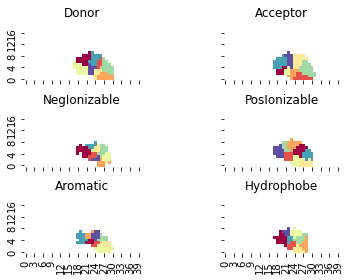

In [6]:
## View the clustering performed by mGAP
fig = som_selection.VisualisePartitioning()

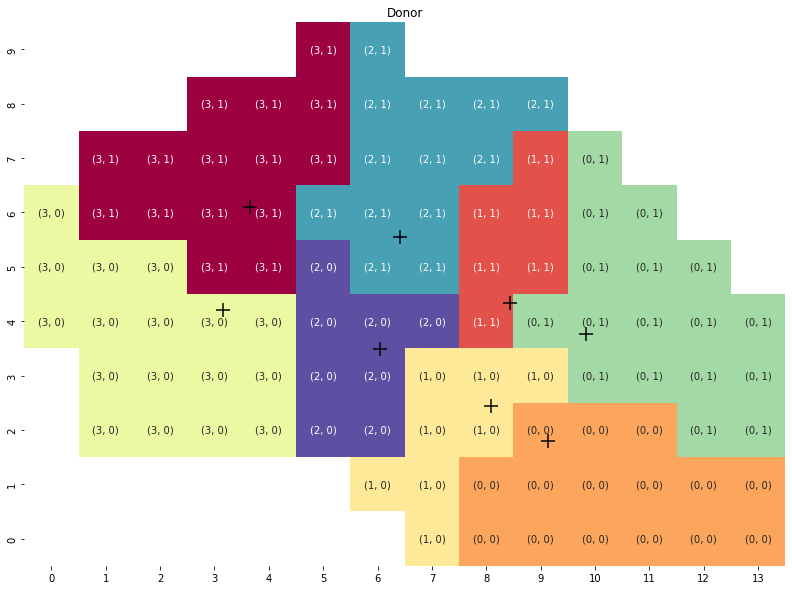

In [7]:
som_selection.VisualisePartitioningDetail(pharmacophore = 'Donor')

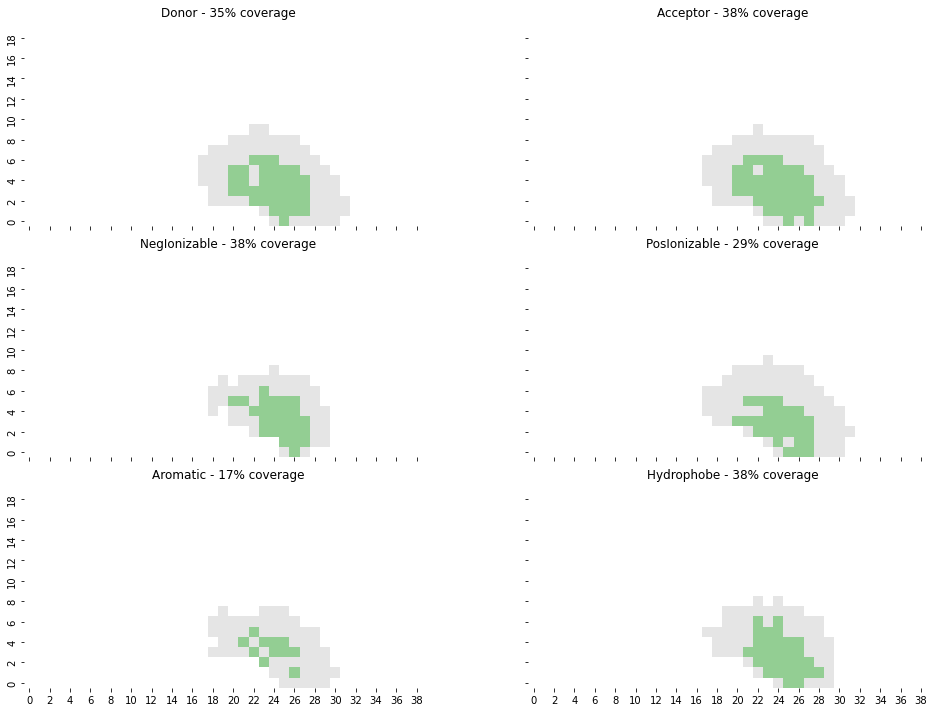

In [8]:
## mGAP coverage
fig = som_selection.VisualiseCoverage()

## bbGAP classic partitioning method

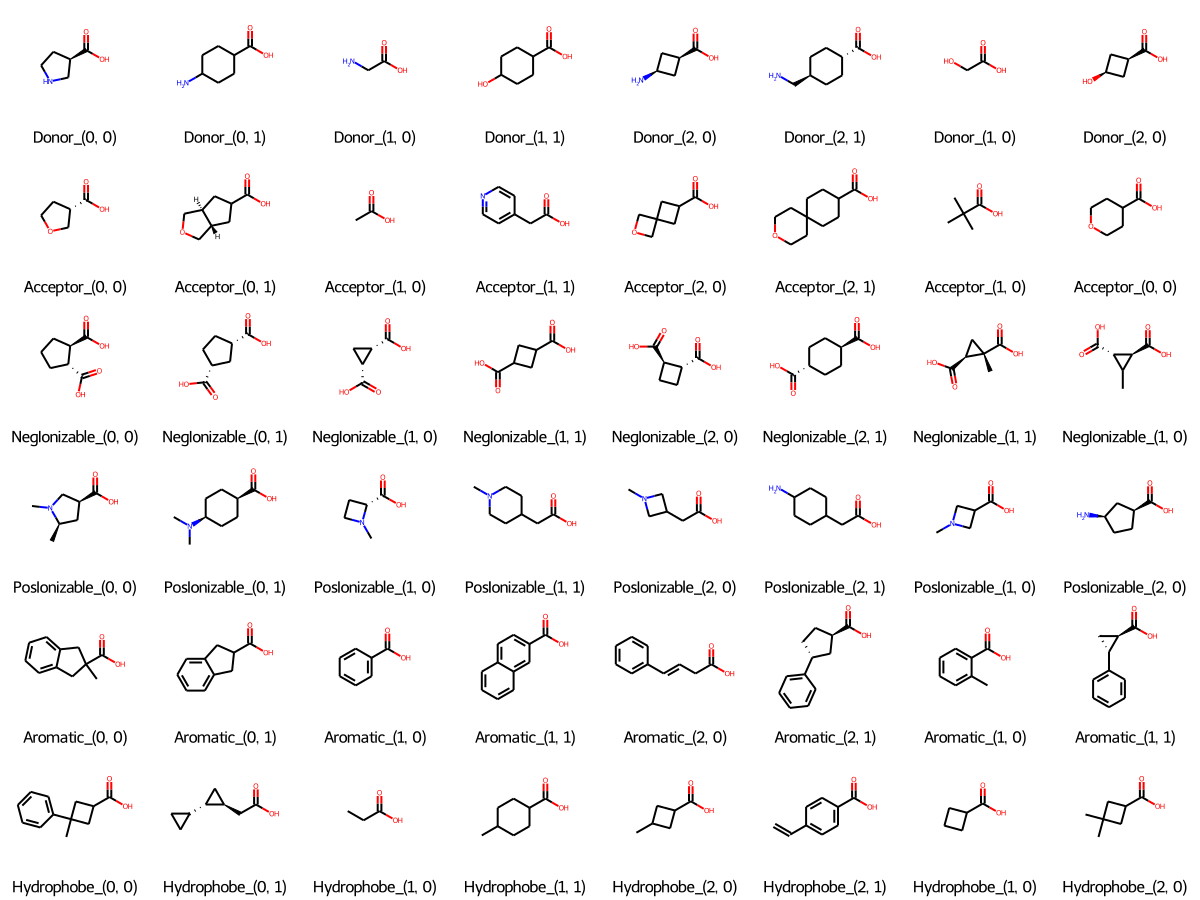

In [9]:
classic_selection = Picker(ref_file = input_ref, 
                            bin_file = input_bin, 
                            n = n_select,  # How many compounds to select
                            method = 'classic', # Which clustering method to use
                            pharmacophores = '*', # Which pharmacophore to select from,
                            select_mode = 1, # How to distribute selection amongst pharmacophore:0- by area covered by pharmacophore, 1 - evenly, 2 - proportionally on a log scale, 3 - proportionally
                            sort = 'MPO',
                            ncpu = 15,
                          use_coverage = False)

## Get smiles as a list
#smiles = list(classic_selection._selection_table['smiles'])
#molnames = list(classic_selection._selection_table.index)
classic_selected_smiles_dict = classic_selection.GetSelectionDict()
classic_selected_molnames = classic_selection.GetSelectionIDs()
classic_selection.DrawSelectedMols(align_smiles = 'CC(=O)O', fontsize = 16)

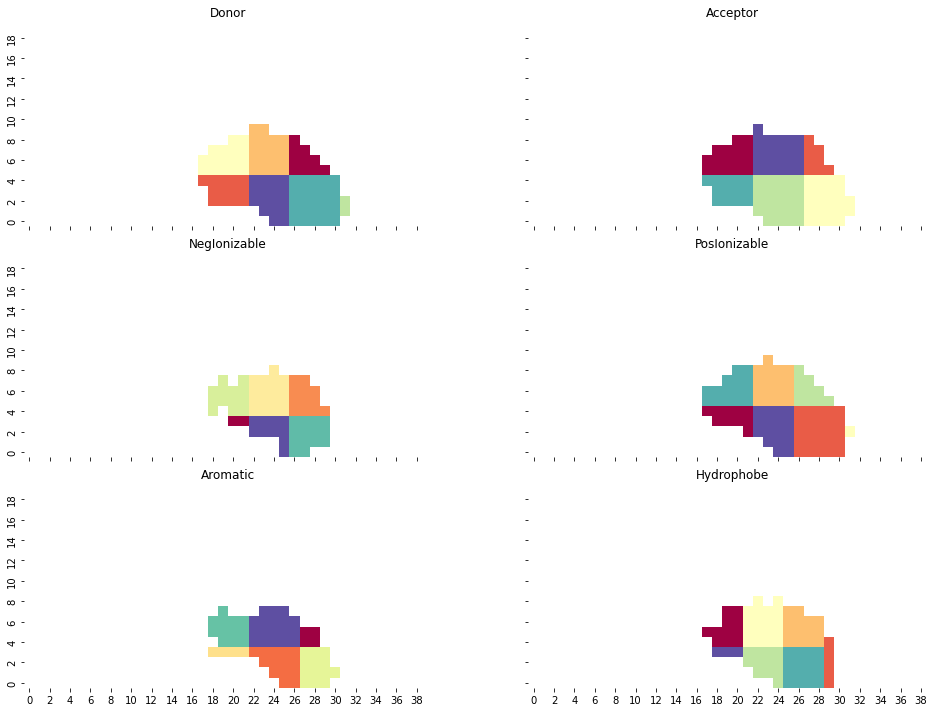

In [10]:
## View the clustering performed by mGAP
fig = classic_selection.VisualisePartitioning()

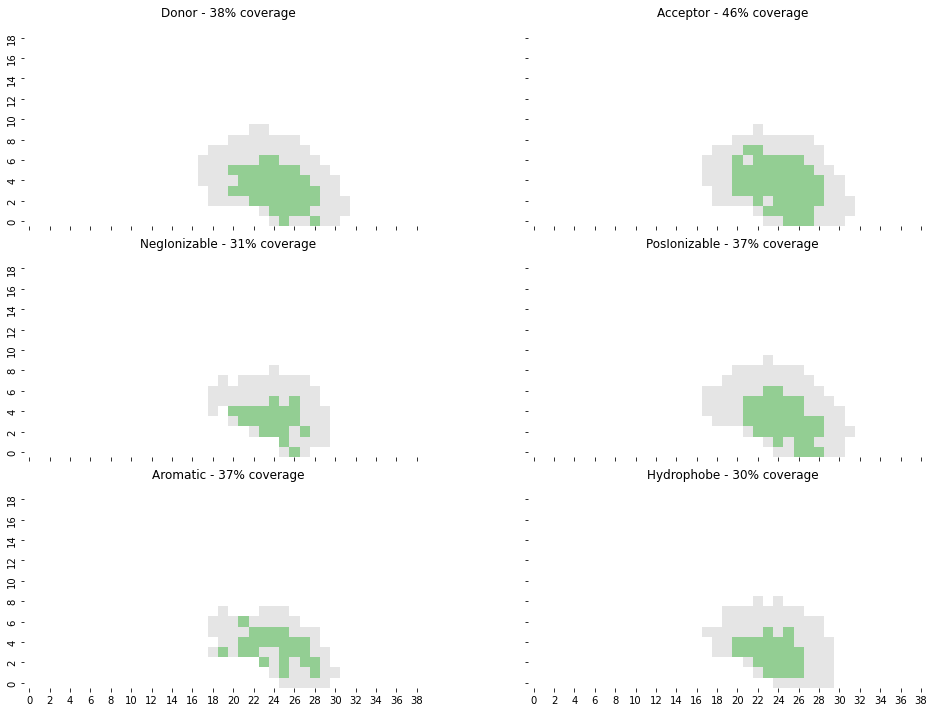

In [11]:
fig = classic_selection.VisualiseCoverage()

## Full coverage

In [12]:
full_selection = Picker(ref_file = input_ref, 
                        bin_file = input_bin, 
                               n = 1,  # How many compounds to select
                          method = 'full_coverage', # Which partitioning method to use
                  pharmacophores = '*', # Which pharmacophore to select from,
                        select_mode = 1, # How to distribute selection amongst pharmacophore:0- by area covered by pharmacophore, 1 - evenly, 2 - proportionally on a log scale, 3 - proportionally
                            ncpu = 10,  # Number of cpus to use,
                            sort = 'MPO',
                            tanimoto = 0)

full_selected_smiles_dict = full_selection.GetSelectionDict()
full_selected_molnames = full_selection.GetSelectionIDs()

print(f'full coverage achieved with {len(full_selected_molnames)} picks')
mpo_mean = full_selection.GetDataTable()['MPO'].loc[full_selected_molnames].mean()
print(f'MPO mean : {mpo_mean}')
full_selection.DrawSelectedMols(align_smiles = 'CC(=O)O')


full coverage achieved with 265 picks
MPO mean : 0.24202658483752212


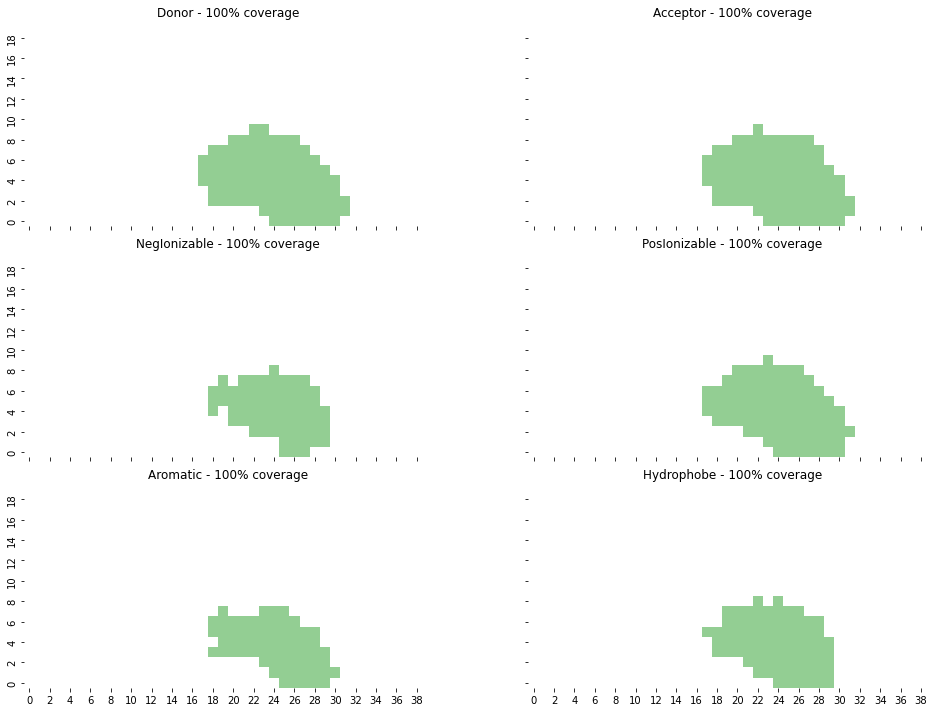

In [13]:
fig = full_selection.VisualiseCoverage()

In [14]:
## Get the molecule objects as a list for the non bbSelect methods
mols = []
align_mol = Chem.MolFromSmiles('CC(=O)O')
AllChem.Compute2DCoords(align_mol)
for sm, ID in zip(smiles, molnames):
    mol = Chem.MolFromSmiles(sm)
    AllChem.GenerateDepictionMatching2DStructure(mol , align_mol)
    mols.append(mol)

## Random selection
> - Take a random sample of compounds from the set

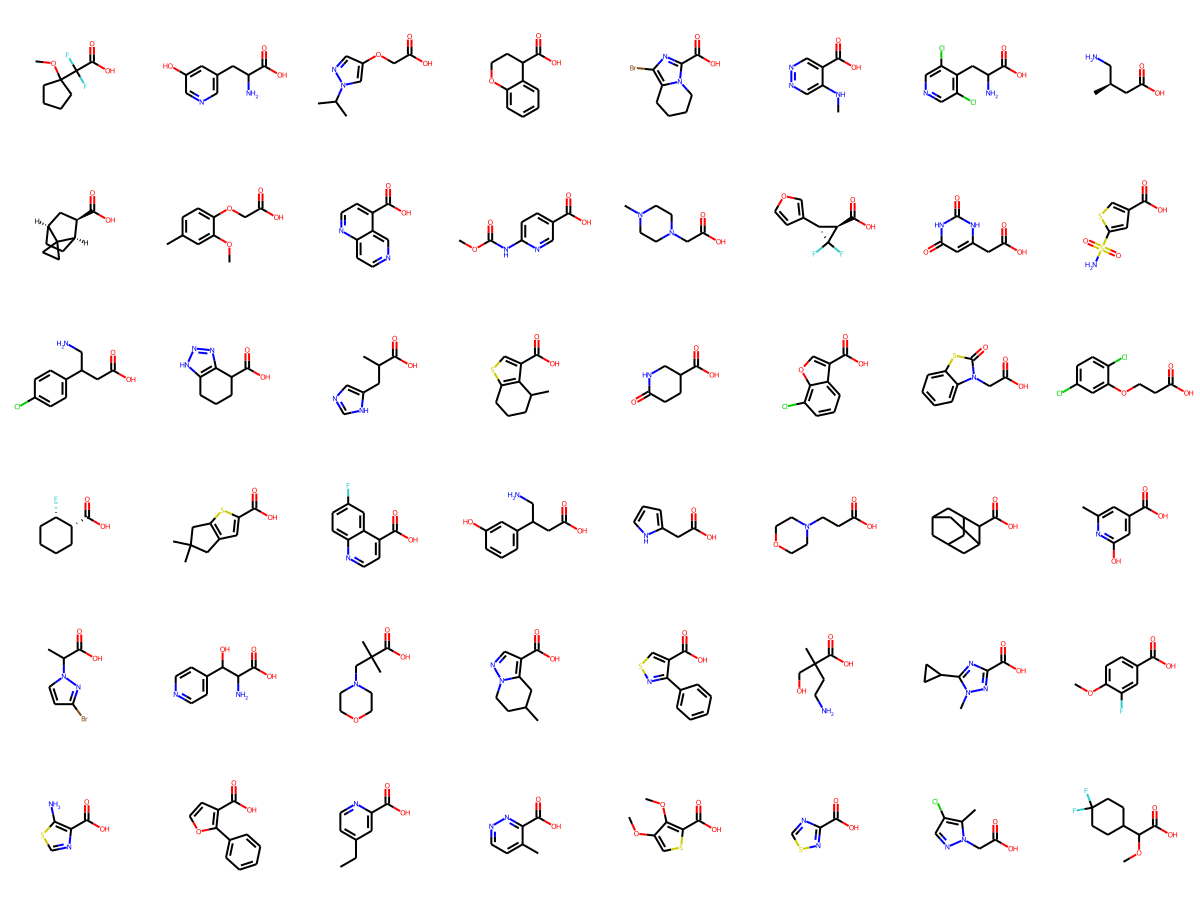

In [15]:
## Get random selection
molnames = list(som_selection._selection_table.index)
random.seed(3)
random_picks = random.sample([i for i,j in enumerate(mols)], n_select)
random_molnames = [molnames[x] for x in random_picks]
Draw.MolsToGridImage([mols[x] for x in random_picks], molsPerRow=8, maxMols=100, subImgSize=(150,150))

/home/fr645797/.conda/envs/a_francesco_env_22/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/fr645797/.conda/envs/a_francesco_env_22/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


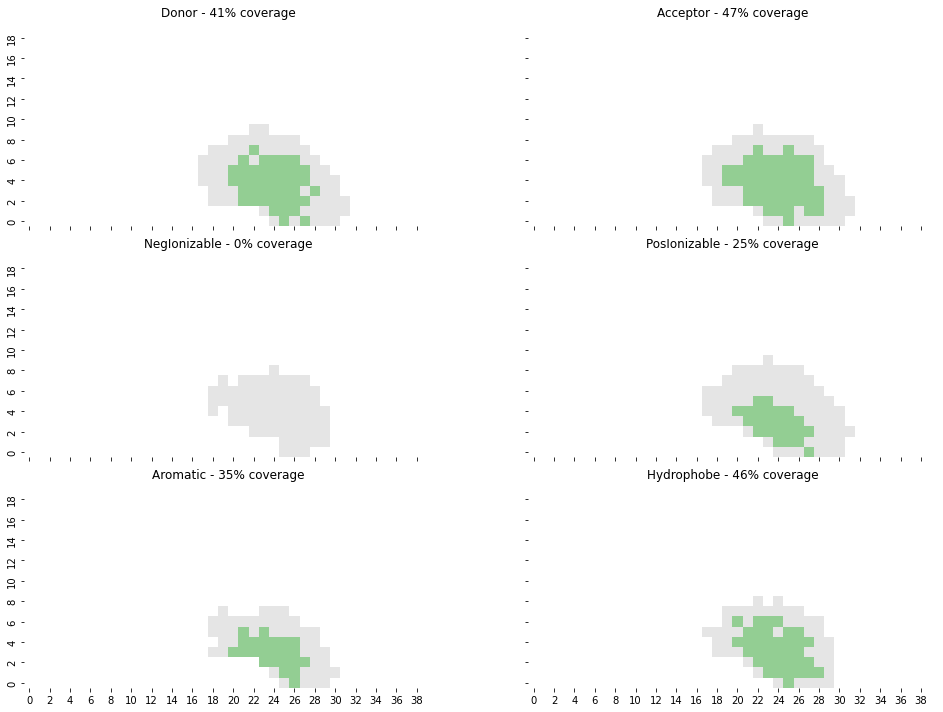

In [16]:
## Random coverage
coverage = classic_selection.SimulateCoverage(molnames = random_molnames)

## Sphere-exclusion clustering

> - Butina method from rdkit.blogspot.com/2020/11/sphere-exclusion-clustering-with-rdkit.html
> - Refs:
>> - D. Butina,          J. Chem. Inf. Comput. Sci. 1999, 39, 747
>> - A. Gobbi, M. Lee,   J. Chem. Inf. Comput. Sci. 2003, 43, 1, 317
>> - R. Sayle            https://raw.githubusercontent.com/rdkit/UGM_2019/master/Presentations/Sayle_Clustering.pdf


56


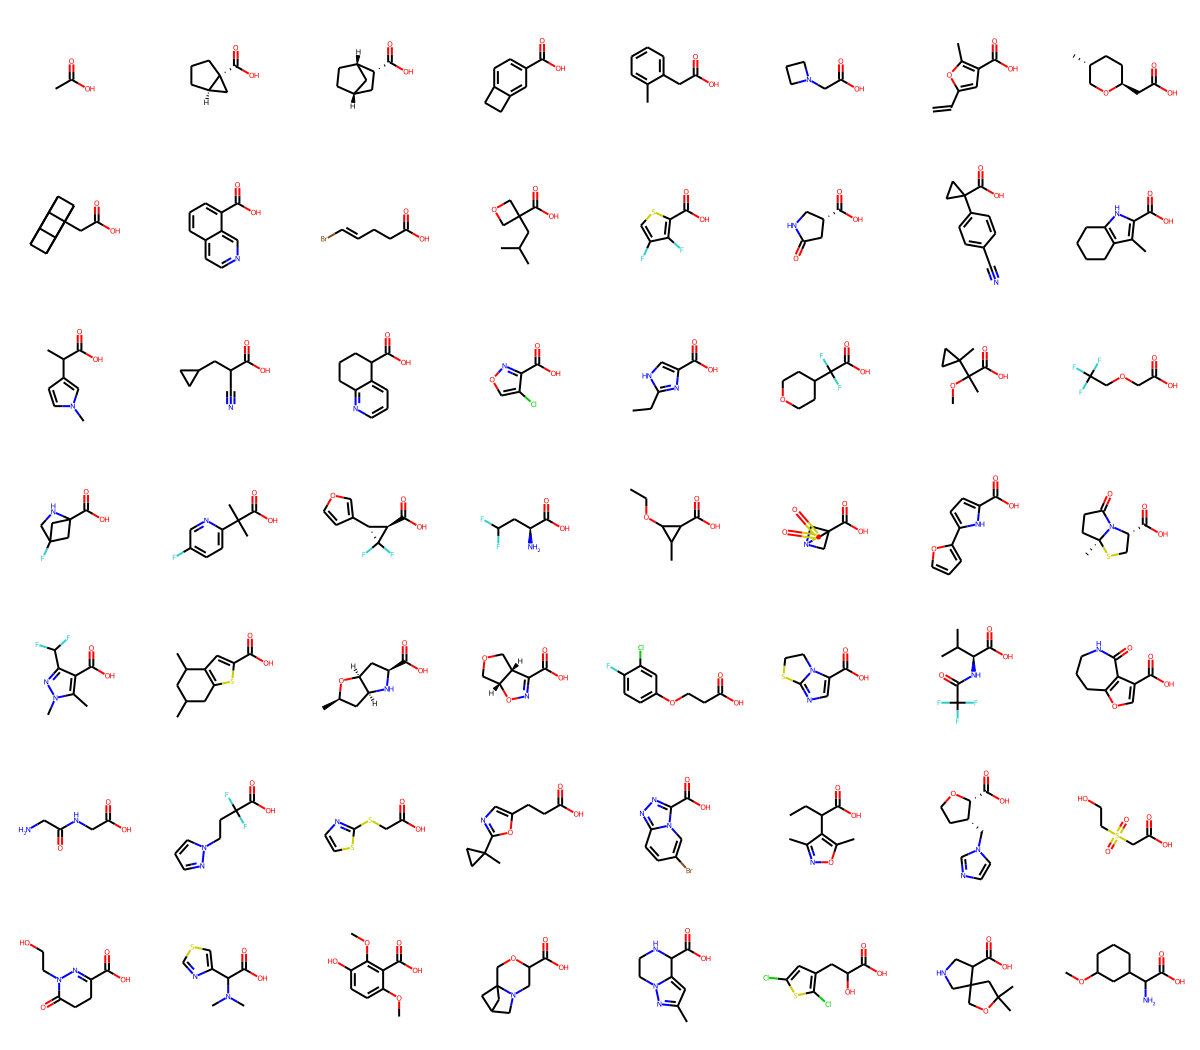

In [17]:
## Calculate fingerprints
## Equivalent to ECFP4 (diameter used in ECFP, radius used in Morgan)
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m,2,2048) for m in mols]

## Start LeaderPicker object. This performs a fast sphere exclusion clustering without calculating similarity matrix
lp = rdSimDivPickers.LeaderPicker()

## Set similarity threshold for sphere exclusion clustering (minimum distance between cluster centroids)
thresh = 0.79

## Get 'picks' which are essentially the cluster centroids, giving the indices in the list of molecules of the selected compounds
sphex_picks = lp.LazyBitVectorPick(fps,len(fps),thresh)
print(len(sphex_picks))
sphex_molnames = [molnames[x] for x in sphex_picks]
Draw.MolsToGridImage([mols[x] for x in sphex_picks], molsPerRow=8, subImgSize=(150,150), maxMols=100)

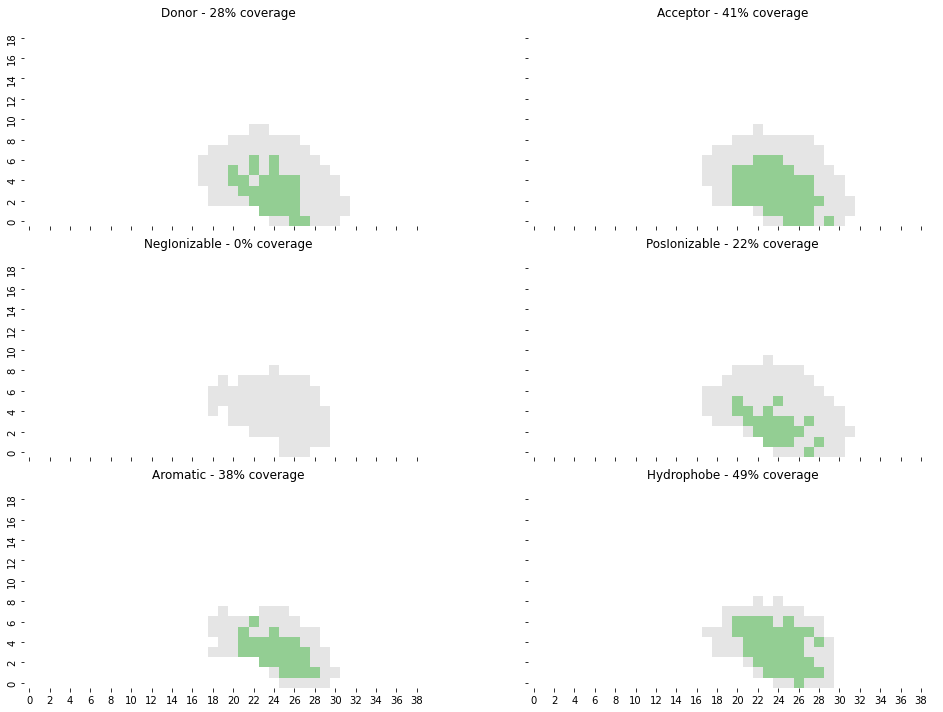

In [18]:
## Sphex coverage
coverage = classic_selection.SimulateCoverage(molnames = sphex_molnames)

## MaxMin picker
> - MaxMin picker algorithm taken from http://rdkit.blogspot.com/2013/10/fingerprint-thresholds.html and https://github.com/greglandrum/rdkit_blog/blob/master/notebooks/MaxMinPickerRevisited.ipynb
> - Picks things on edge of space. Is in paper Agrafiotis
> - refs:
>> - Ashton, M. et. al., Quant. Struct.-Act. Relat., 21 (2002), 598
>> - http://rdkit.blogspot.com/2014/08/optimizing-diversity-picking-in-rdkit.html
>> - http://rdkit.blogspot.com/2014/08/optimizing-diversity-picking-in-rdkit.html
>> - http://rdkit.blogspot.com/2014/08/optimizing-diversity-picking-in-rdkit.html
>> - https://github.com/greglandrum/rdkit_blog/blob/master/notebooks/MaxMinPickerRevisited.ipynb

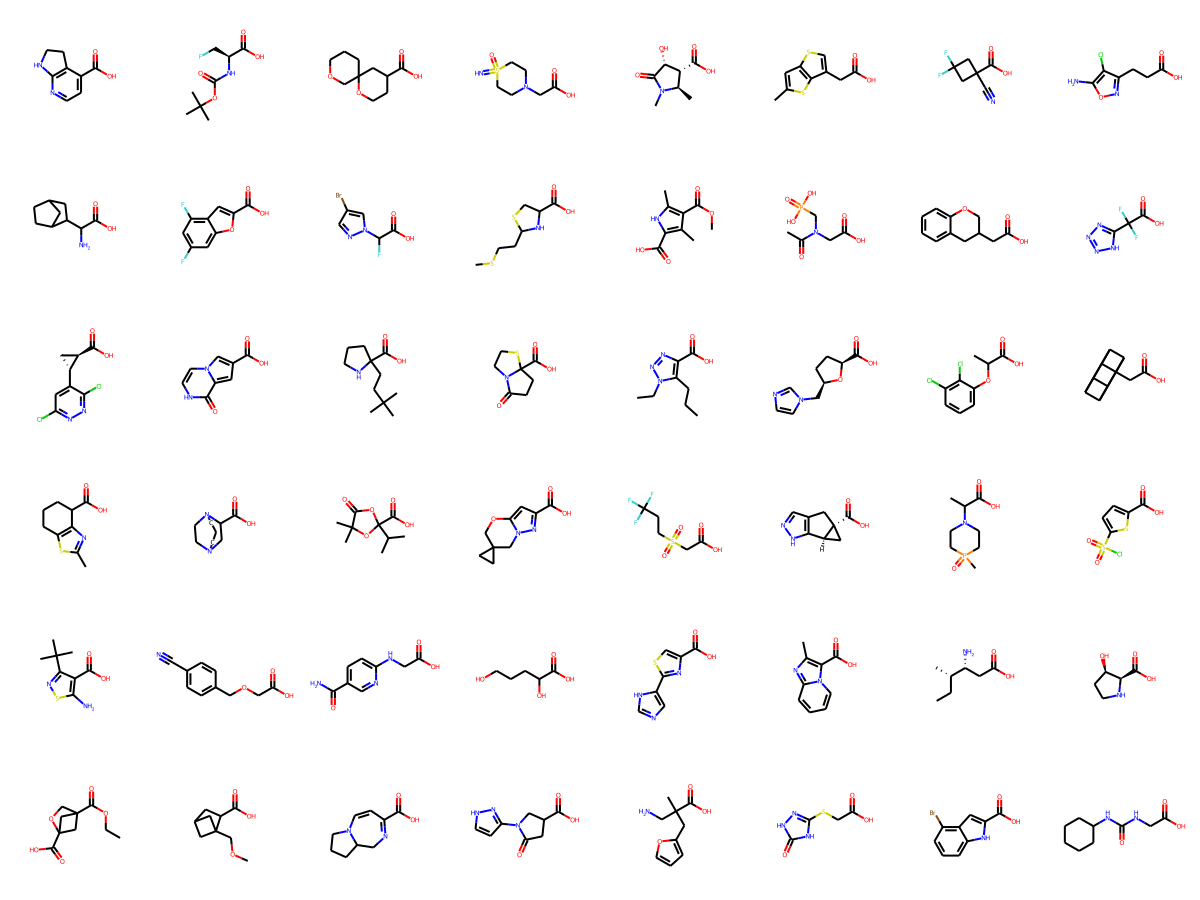

In [19]:
## Have to specify distance function. Here, you make it in a funcion
def fn(i,j,fps=fps):
    return 1.-DataStructs.TanimotoSimilarity(fps[i],fps[j])

## Start MaxMinPicker class
mmp =SimDivFilters.MaxMinPicker()
MaxMin_picks = mmp.LazyPick(fn,len(fps), n_select, seed=3)
MaxMin_molnames = [molnames[x] for x in MaxMin_picks]
Draw.MolsToGridImage([mols[x] for x in MaxMin_picks], molsPerRow=8, subImgSize=(150,150), maxMols=100)

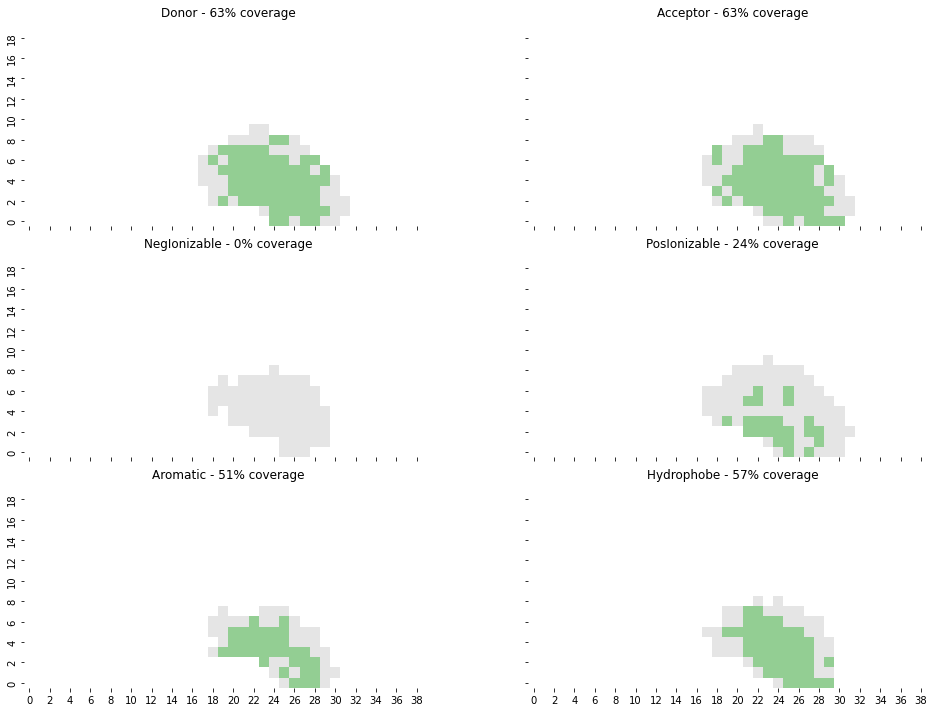

In [20]:
## MaxMin coverage
fig = classic_selection.SimulateCoverage(molnames = MaxMin_molnames)

# K-means clustering

> - Perform k-Means clustering on morgan2 fingerprints (equivalent to ECFP4)


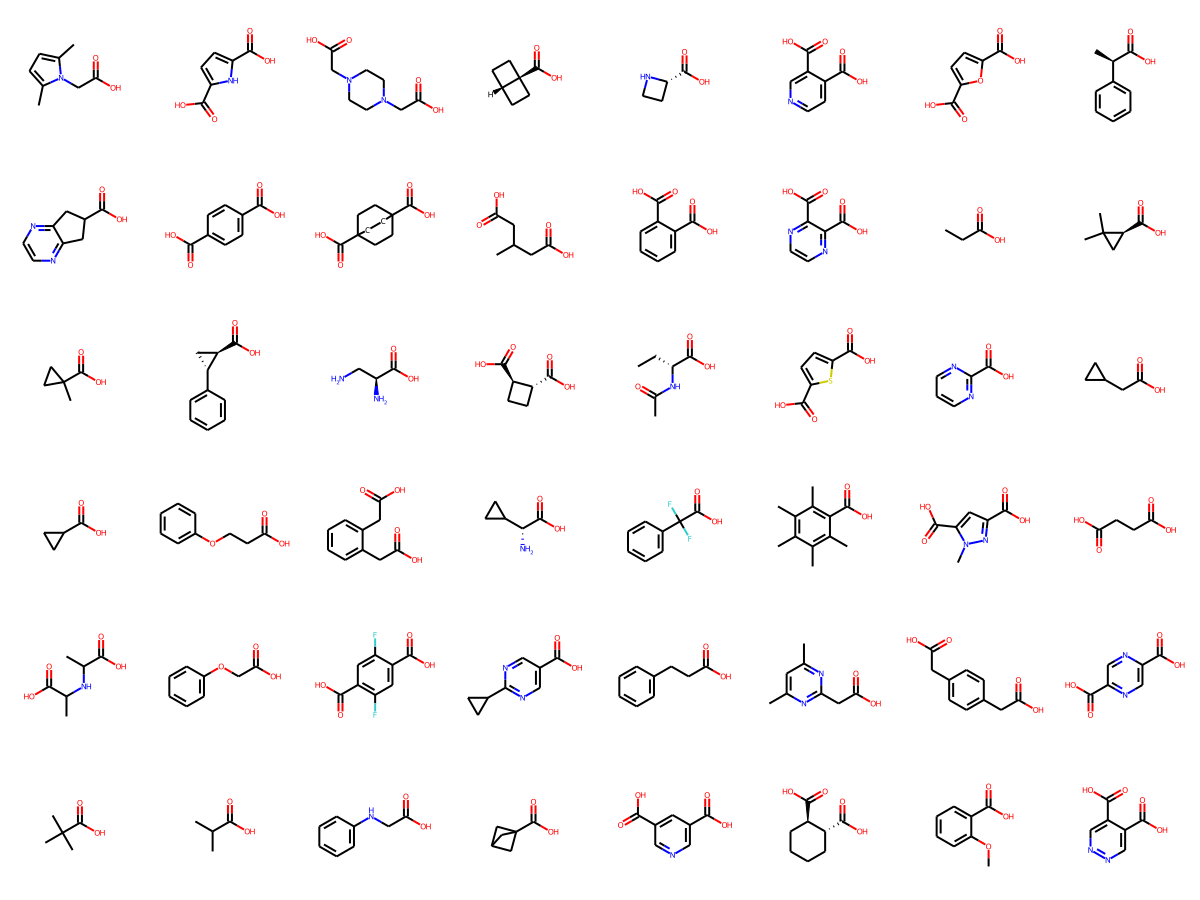

In [21]:
## Convert fingerprints into a list
fps_list = [list(fp) for fp in fps]

## Set the selection size e.g. number of k-means clusters
num_clusters = n_select

## Initialise the k-means clustering object
km = KMeans(
    n_clusters=num_clusters, init='k-means++',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=3)

## Perform k-means clustering
y_km = km.fit(fps_list)

## Number of iterations. If less that max_iter, convergence has been met
# y_km.n_iter_

## Get the clusters and the values of the centroids
m_clusters = y_km.labels_.tolist()
centers = np.array(y_km.cluster_centers_)

## Find the data point closest to the cluster centroid
k_means_molnames = []
k_means_picks = [] ## Indices of selection

## Iterate over the clusters

for i in range(num_clusters):
    ## Get the centroid vector
    center_vec = centers[i]
    
    ## Get the indices of the data points that are within each cluster
    data_idx_within_i_cluster = [ idx for idx, cluster_num in enumerate(m_clusters) if cluster_num == i ]
    
    ## Create a matrix where the number of rows = number of points in cluster and is the legnth of the data vector (length of fingerprint)
    ## This is a 'slice' of the data within the original data set which come from the cluster
    one_cluster_tf_matrix = np.zeros( (  len(data_idx_within_i_cluster) , centers.shape[1] ) )
    
    ## Iterate over the compounds within the cluster
    for row_num, data_idx in enumerate(data_idx_within_i_cluster):
        
        ## Get the fingerprint for the compound
        one_row = fps_list[data_idx]
        
        ## Set the fingerprint within the matrix
        one_cluster_tf_matrix[row_num] = one_row
    
    ## Calculate the closest compound to the centroid vector
    closest, distance = pairwise_distances_argmin_min(center_vec.reshape(1, -1), one_cluster_tf_matrix)
    
    ## Get the index of the closest compound to the centroid vector in the slice cluster list
    closest_idx_in_one_cluster_tf_matrix = closest[0]
    
    ## Get the index of the closest compound in the larger data set
    closest_data_row_num = data_idx_within_i_cluster[closest_idx_in_one_cluster_tf_matrix]
    
    ## Get the molname
    data_id = molnames[closest_data_row_num]
    
    k_means_picks.append(closest_data_row_num)
    k_means_molnames.append(data_id)

k_means_molnames = list(set(k_means_molnames))
Draw.MolsToGridImage([mols[x] for x in k_means_picks], subImgSize=(150,150), molsPerRow=8, maxMols=100)

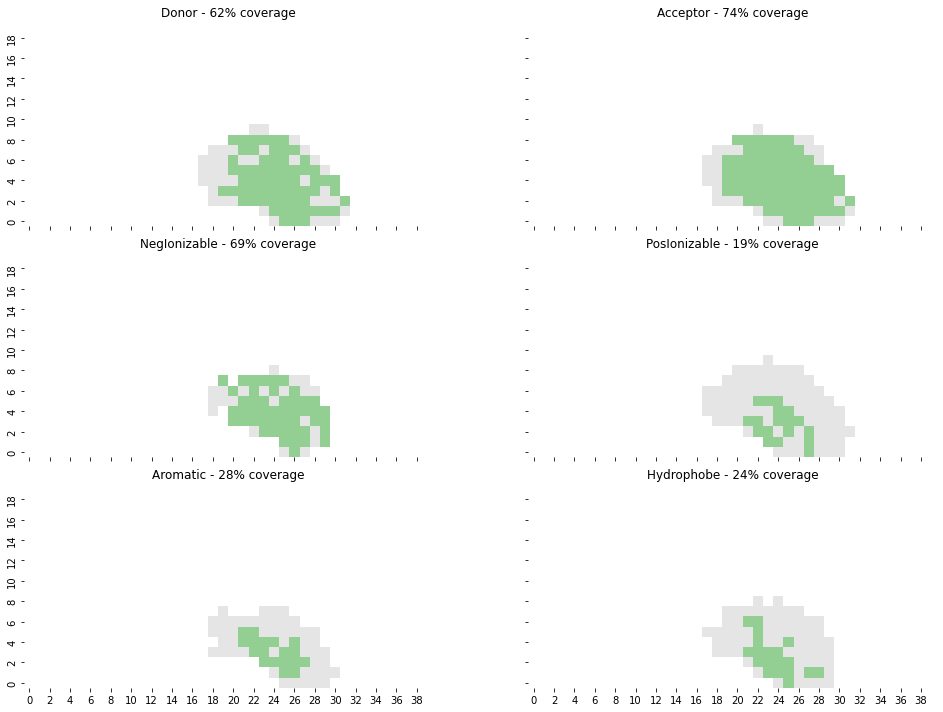

In [22]:
## k_means coverage
fig = classic_selection.SimulateCoverage(molnames = k_means_molnames)